# Gaussian Mixture Model Clustering

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.distributions as dist
from torch.distributions import Uniform, Normal
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class GMMClustering(nn.Module):
    def __init__(self, D, K, hidden_size, a=0, b=1, dropout=0.1):
        """
        a, b are the prior knowledge of μ range such that μ ∈ [a, b].
        """
        super(GMMClustering, self).__init__()
        self.D = D
        self.K = K
        ## todo: maybe use the prior knowledge to initialize M
        ## such that μs are uniformly distributed in the data space
        #self.M = nn.Parameter(torch.randn(K, D)) # μs
        self.M = nn.Parameter(Uniform(a, b).sample((K, D))) #μs
        self.logS = nn.Parameter(torch.randn(K, D)) # logσs
        ## π is the parameter of the Categorical distribution
        self.x2logπ = nn.Sequential(MLP(D, hidden_size, K, dropout),
                                    nn.LogSoftmax(dim=1))
        self.d_uniform = Uniform(0, 1)

    def forward(self, x, τ=1.0):
        """
        Input:
          x (batch, D)
        Output:
          z (batch, K)
          l (scalar): negative log-likehood
        """
        z = self.encoder(x, τ)
        μ, σ = self.decoder(z)
        l = NLLGauss(μ, σ, x)
        return z, l

    def encoder(self, x, τ):
        """
        Input:
          x (batch, D)
        Output:
          z (batch, K): Gumbel-softmax samples.
        """
        logπ = self.x2logπ(x)
        u = self.d_uniform.sample(logπ.size())
        g = -torch.log(-torch.log(u))
        z = F.softmax((logπ + g)/τ, dim=1)
        return z

    def decoder(self, z):
        """
        Input:
          z (batch, K)
        Output:
          μ (batch, D)
          σ (batch, D)
        """
        μ = torch.mm(z, self.M)
        σ = torch.exp(torch.mm(z, self.logS))
        return μ, σ

def NLLGauss(μ, σ, x):
    """
    μ (batch, D)
    σ (batch, D)
    x (batch, D)
    """
    return -torch.mean(Normal(μ, σ).log_prob(x))

class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size,
                 dropout, use_selu=True):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.nonlinear_f = F.selu if use_selu else F.leaky_relu
        self.dropout = nn.Dropout(dropout)
    def forward(self, x):
        h1 = self.dropout(self.nonlinear_f(self.fc1(x)))
        return self.fc2(h1)

In [3]:
μ1, Σ1 = torch.tensor([0.0, 0.0]), torch.diag(torch.tensor([1.0, 2.0]))
d1 = dist.MultivariateNormal(μ1, Σ1)
μ2, Σ2 = torch.tensor([5.0, 5.0]), torch.diag(torch.tensor([1.0, 1.0]))
d2 = dist.MultivariateNormal(μ2, Σ2)

X1 = d1.sample((500,))
X2 = d2.sample((500,))
x = torch.cat([X1, X2])

(-3.43205326795578, 9.158250749111176, -4.71671040058136, 9.039412331581115)

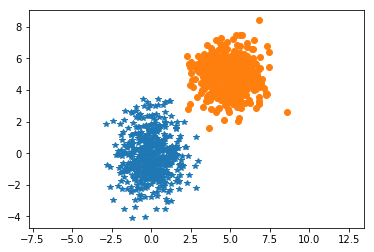

In [4]:
Y1 = X1.numpy()
Y2 = X2.numpy()
plt.plot(Y1[:, 0], Y1[:, 1], "*")
plt.plot(Y2[:, 0], Y2[:, 1], "o")
plt.axis('equal')

In [5]:
D, K = 2, 2
gmmc = GMMClustering(D, K, 64, a=0, b=1)
optimizer = torch.optim.Adam(gmmc.parameters())

In [6]:
for i in range(12000):
    z, l = gmmc(x)
    if i % 1000 == 0:
        print("loss: {}".format(l.item()))
    optimizer.zero_grad()
    l.backward()
    optimizer.step()

loss: 2.8473756313323975
loss: 2.1456844806671143
loss: 1.853241205215454
loss: 1.5784493684768677
loss: 1.486061453819275
loss: 1.491107702255249
loss: 1.4861587285995483
loss: 1.5030301809310913
loss: 1.4873088598251343
loss: 1.4947954416275024
loss: 1.497831106185913
loss: 1.4902169704437256


In [7]:
z, l = gmmc(x)
val, idx = torch.max(z, dim=1)

In [8]:
gmmc.M

Parameter containing:
tensor([[-0.1006, -0.2091],
        [ 5.0500,  5.0001]], requires_grad=True)

In [9]:
print(idx[:500].sum())
print(idx[500:].sum())

tensor(1)
tensor(495)
